# Topo Time Series MWTA

## Intro
* **Date**: 1/13/21
* **What**: I'm basically doing time-series mwta with strong lateral excitation to promote the formation of topological connections.  I also think I figured out how to prevent training from going totally haywire by clipping the reconstruction error.
* **Why**: Basically the more useful connections between different prototypes I can find, the better.  Begin able the organize the prototypes and promote certain neurons firing together is super important when moving from an invariant representation that can represent many things to one particular configuration that corresponds with that representation.
* **Hopes**: I basically just want to see interesting topological connections.
* **Limitations**: This has already worked before, but that obviously doesn't mean I won't run into difficulties.  I just don't know what those difficulties are yet.

## Code

In [1]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from tensorflow.keras.datasets import mnist
from tqdm import tqdm

(x_tr, _), _ = mnist.load_data()

x_tr = x_tr / 255.0

In [2]:
t_sl = 30 # Tapestry side length
m_sl = 28 # Side length of each images

tapestry = np.zeros((t_sl * m_sl, t_sl * m_sl))

x_i = 0

for x in range(t_sl):
    for y in range(t_sl):

        tapestry[y * m_sl : (y + 1) * m_sl, x * m_sl : (x + 1) * m_sl] = x_tr[x_i]
        x_i += 1
        
tapestry[(t_sl - 1) * m_sl:, :] = tapestry[: m_sl, :]
tapestry[:, (t_sl - 1) * m_sl:] = tapestry[:, : m_sl]

<IPython.core.display.Javascript object>


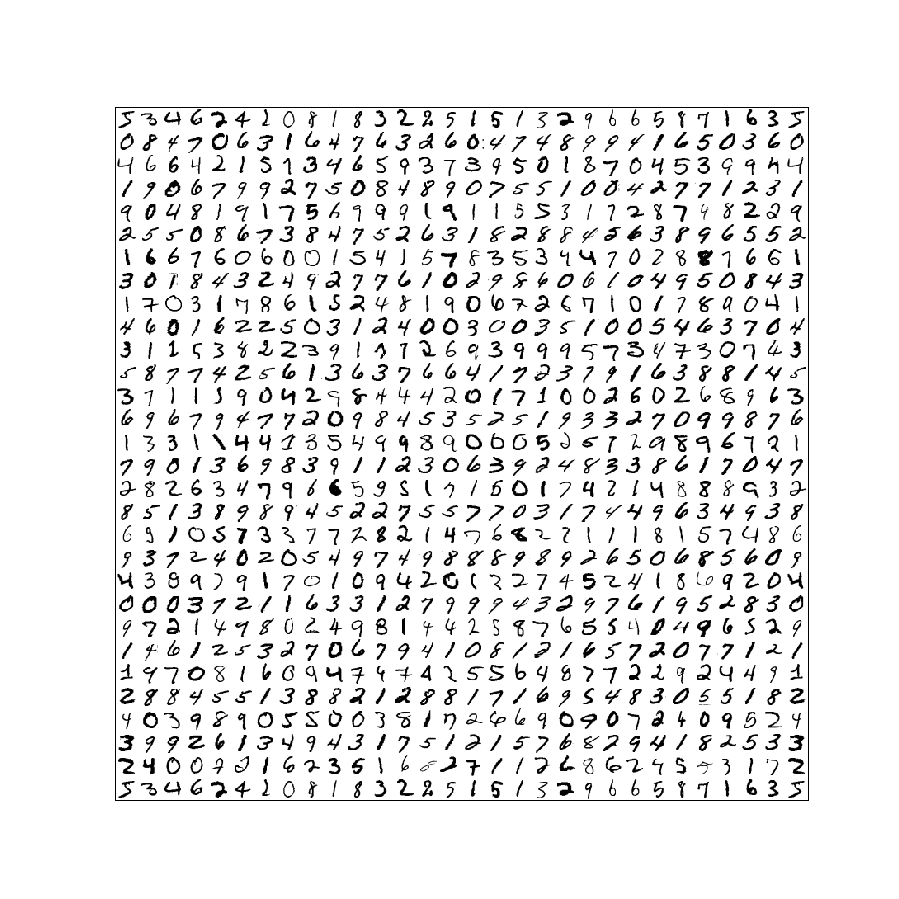

In [3]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))
plt.xticks([])
plt.yticks([])
plt.imshow(tapestry, cmap="gray_r")

In [4]:
x_o = 420
y_o = 420

sl = 20

x = x_o
y = y_o

v_x = 0
v_y = 0

v_max = 3

a_x = np.random.uniform(-1, 1)
a_y = np.random.uniform(-1, 1)

img_count = 10_000
imgs = []

del_t = 1

for i in range(img_count):
    if i % 20 == 0:
        a_x = np.random.uniform(-1, 1)
        a_y = np.random.uniform(-1, 1)
        
    x += v_x * del_t
    y += v_y * del_t
    v_x = np.clip(v_x + (a_x * del_t), -v_max, v_max)
    v_y = np.clip(v_y + (a_y * del_t), -v_max, v_max)
    
    x_f = int(x) % ((t_sl - 1) * m_sl)
    y_f = int(y) % ((t_sl - 1) * m_sl)
    
    imgs.append(tapestry[y_f: y_f + sl, x_f : x_f + sl])

<IPython.core.display.Javascript object>


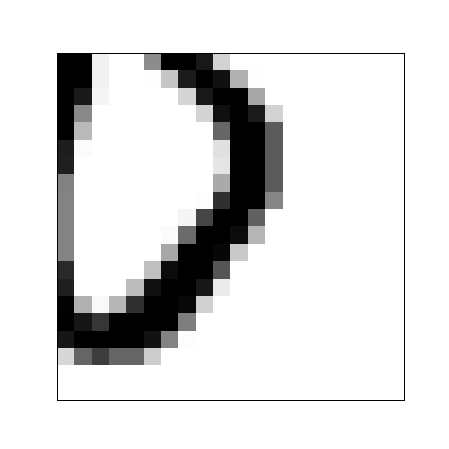

In [5]:
%matplotlib notebook
fig = plt.figure(figsize=(5, 5))

ims = []
for i in range(500):
    im = plt.imshow(imgs[i], cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])
plt.show()

In [6]:
img_array = np.array(imgs)
ts_data = img_array.reshape(-1, sl ** 2)
gp_data = cp.asarray(ts_data)

In [7]:
def draw_weights(w, Kx, Ky, s_len, fig):
    tapestry = np.zeros((s_len * Ky, s_len * Kx))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * s_len: (y + 1) * s_len, x * s_len: (x + 1) * s_len] = w[w_i].reshape(s_len, s_len)
            w_i += 1
            
    plt.clf()        
    max_val = np.max(tapestry)
    im = plt.imshow(tapestry, cmap="Greys", vmax=max_val)
    fig.colorbar(im, ticks=[0, max_val])
    plt.axis("off")
    fig.canvas.draw()

## Analysis Dialog

Here we go.

<IPython.core.display.Javascript object>


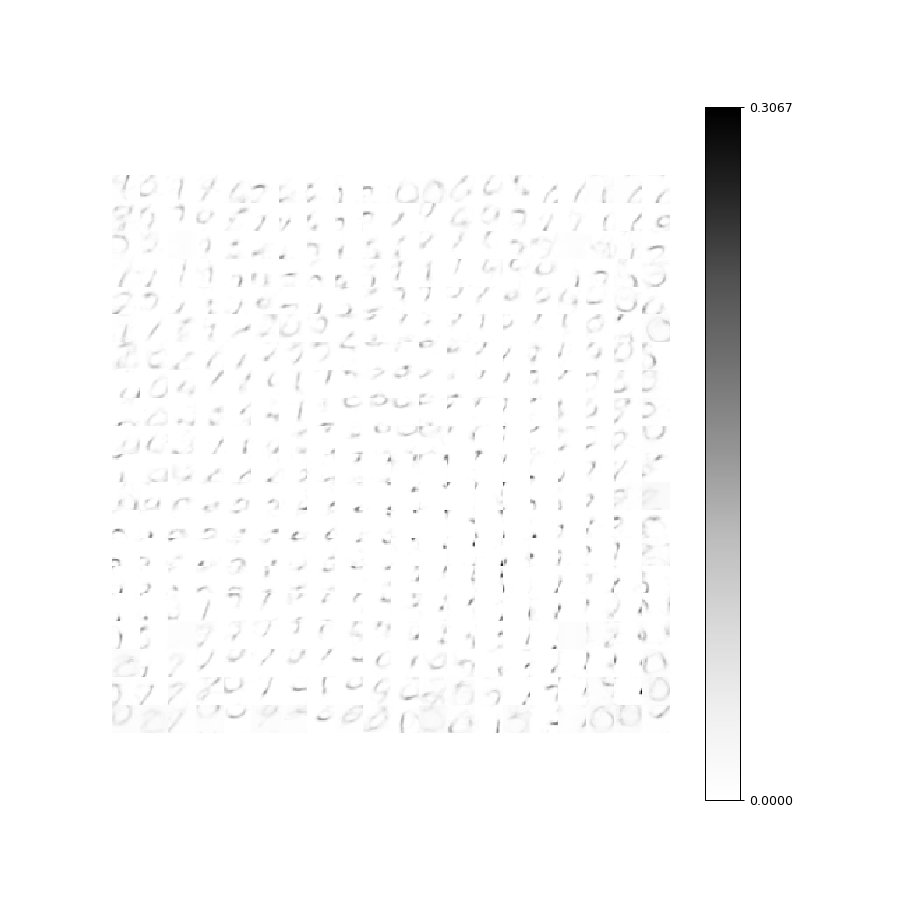

100%|██████████| 10000/10000 [00:04<00:00, 2090.28it/s]


In [12]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 5
T_s = 10_000

Kx = 20
Ky = 20
N = Kx * Ky
m_len = sl ** 2
tr_len = img_count
ex = 2

prec = 1e-10

n_w = 5 #Number of winners

# Feedforward
w = cp.random.uniform(.15, .16, (N, m_len))
xi = 0.01

lat_ex = []

for y in range(Ky):
    for x in range(Kx):
        curr_ex = np.zeros((Ky, Kx))
        curr_ex[max(0, y - ex): min(Ky - 1, y + ex + 1), max(0, x - ex): min(Kx - 1, x + ex + 1)] = 0.1
        lat_ex.append(curr_ex.reshape(-1))
    
lat_ex = cp.array(lat_ex)
cp.fill_diagonal(lat_ex, 0)

for ep in range(Nep):
    inputs = gp_data[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        p += lat_ex @ p
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
#         e = cp.clip(v - r, -1, 1)
        e = v - r
        
        
        w += w * o * (e / mod_r).T * xi
        
    draw_weights(w.get(), Kx, Ky, sl, fig)

Wow, even with 400 neurons it's fascinating to watch the topological connections form.  For some reason, everything goes haywire if I make the lateral connections any stronger than 0.1.  Not sure why that is, but obviously we're still totally getting fantastic topological connections.  Ok, I'm going to up this to 1,600 neurons.

<IPython.core.display.Javascript object>


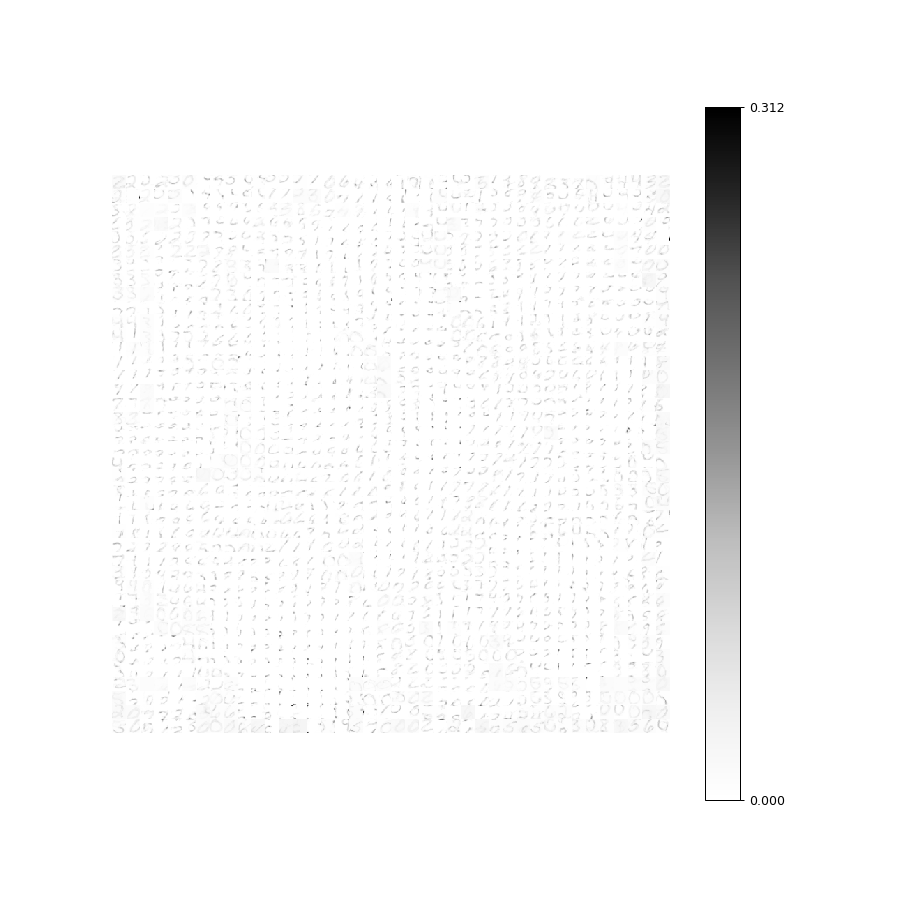

100%|██████████| 10000/10000 [00:06<00:00, 1577.80it/s]


In [15]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 5
T_s = 10_000

Kx = 40
Ky = 40
N = Kx * Ky
m_len = sl ** 2
tr_len = img_count
ex = 2

prec = 1e-10

n_w = 5 #Number of winners

# Feedforward
w = cp.random.uniform(.15, .16, (N, m_len))
xi = 0.03

lat_ex = []

for y in range(Ky):
    for x in range(Kx):
        curr_ex = np.zeros((Ky, Kx))
        curr_ex[max(0, y - ex): min(Ky - 1, y + ex + 1), max(0, x - ex): min(Kx - 1, x + ex + 1)] = 0.1
        lat_ex.append(curr_ex.reshape(-1))
    
lat_ex = cp.array(lat_ex)
cp.fill_diagonal(lat_ex, 0)

for ep in range(Nep):
    inputs = gp_data[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        p += lat_ex @ p
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = cp.clip(v - r, -1, 1)
        
        w += w * o * (e / mod_r).T * xi
        
    draw_weights(w.get(), Kx, Ky, sl, fig)

Holy snoots.  The strong and the weak patterns almost look like a Fourier basis function.  That's absolutely bonkers.  I'm going to try this with 2,500 neurons and more epochs.

<IPython.core.display.Javascript object>


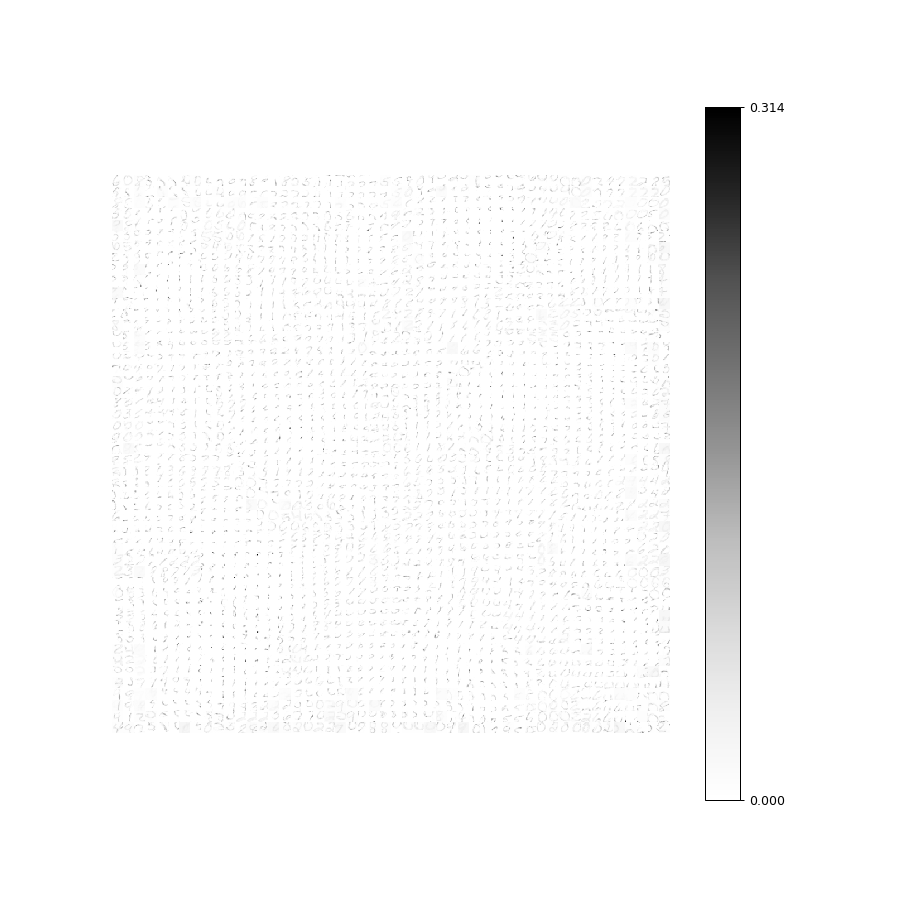

100%|██████████| 10000/10000 [00:07<00:00, 1369.13it/s]


In [16]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 10_000

Kx = 50
Ky = 50
N = Kx * Ky
m_len = sl ** 2
tr_len = img_count
ex = 2

prec = 1e-10

n_w = 5 #Number of winners

# Feedforward
w = cp.random.uniform(.15, .16, (N, m_len))
xi = 0.03

lat_ex = []

for y in range(Ky):
    for x in range(Kx):
        curr_ex = np.zeros((Ky, Kx))
        curr_ex[max(0, y - ex): min(Ky - 1, y + ex + 1), max(0, x - ex): min(Kx - 1, x + ex + 1)] = 0.1
        lat_ex.append(curr_ex.reshape(-1))
    
lat_ex = cp.array(lat_ex)
cp.fill_diagonal(lat_ex, 0)

for ep in range(Nep):
    inputs = gp_data[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        p += lat_ex @ p
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = cp.clip(v - r, -1, 1)
        
        w += w * o * (e / mod_r).T * xi
        
    draw_weights(w.get(), Kx, Ky, sl, fig)

That is absolutely wild.  I've got to try this with just the digits.

But first, here's the animation.

<IPython.core.display.Javascript object>


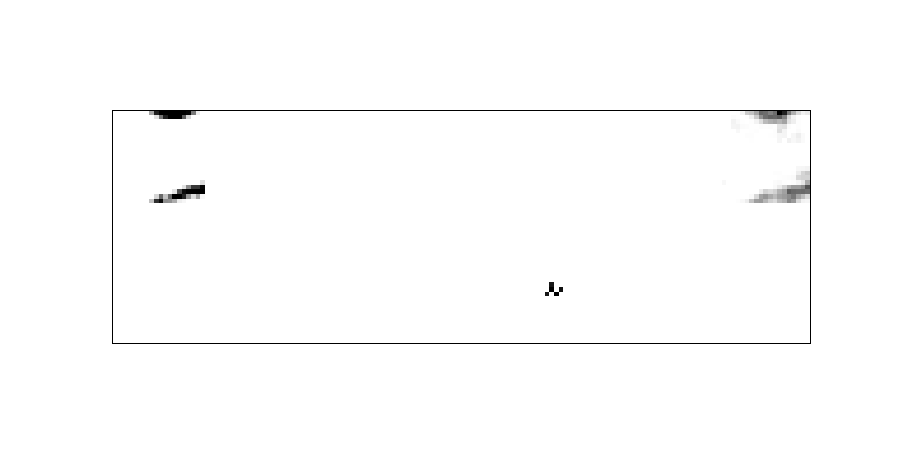

100%|██████████| 500/500 [00:02<00:00, 220.10it/s]


In [22]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

w_np = w.get()
lx_np = lat_ex.get()

ims = []
for i in tqdm(range(500)):
    v = ts_data[i].reshape(-1, 1)
    p = w_np @ v
    p += lx_np @ p
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((N, 1))
    mask[winners] = 1
    o = mask * p
    o = o / max(prec, np.max(o))
    r = w_np.T @ o
    r = r / max(prec, np.max(r))
    
    mini_tap = np.zeros((50, 150))
    
    mini_tap[:20, :20] = v.reshape(20, 20)
    mini_tap[:, 50:100] = o.reshape(50, 50)
    mini_tap[:20, -20:] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=150, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

Ok, I'm going to try something interesting.  I'm going to use a competition value that contains the lateral excitation, but the network trains only on the raw output.  You'll see what I mean.

<IPython.core.display.Javascript object>


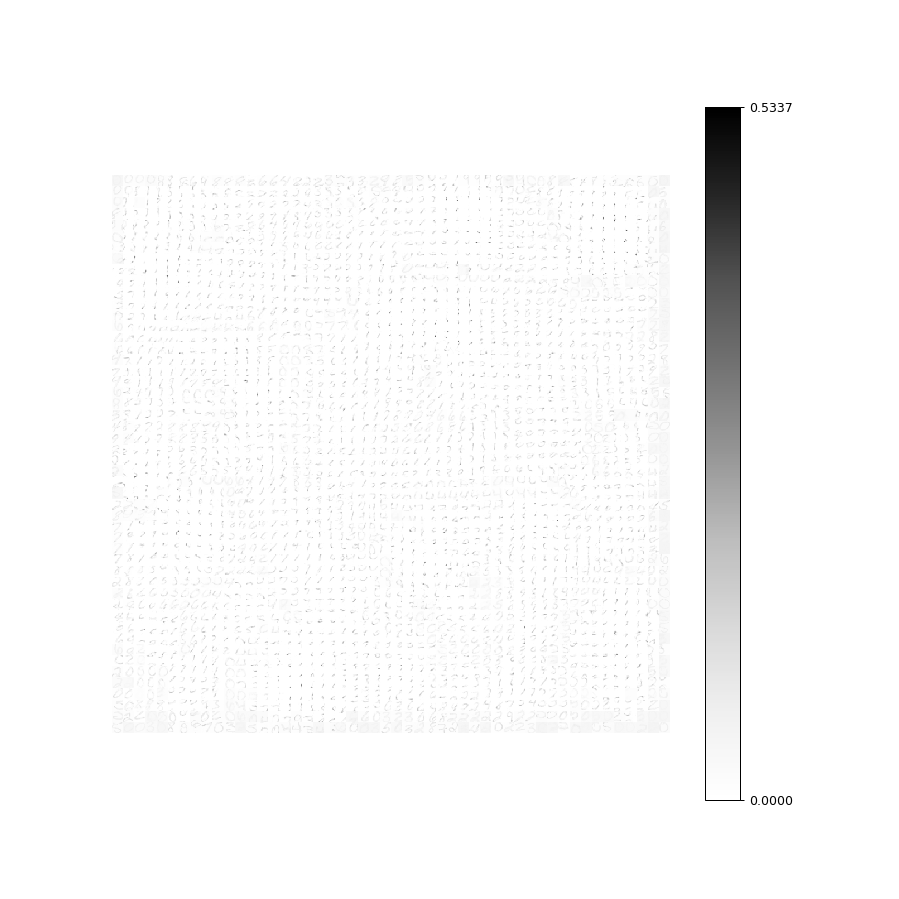

100%|██████████| 10000/10000 [00:07<00:00, 1378.51it/s]


In [23]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 10_000

Kx = 50
Ky = 50
N = Kx * Ky
m_len = sl ** 2
tr_len = img_count
ex = 2

prec = 1e-10

n_w = 5 #Number of winners

# Feedforward
w = cp.random.uniform(.15, .16, (N, m_len))
xi = 0.03

lat_ex = []

for y in range(Ky):
    for x in range(Kx):
        curr_ex = np.zeros((Ky, Kx))
        curr_ex[max(0, y - ex): min(Ky - 1, y + ex + 1), max(0, x - ex): min(Kx - 1, x + ex + 1)] = 0.1
        lat_ex.append(curr_ex.reshape(-1))
    
lat_ex = cp.array(lat_ex)
cp.fill_diagonal(lat_ex, 0)

for ep in range(Nep):
    inputs = gp_data[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        c = p + (lat_ex @ p)
        winners = cp.argsort(c, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = cp.clip(v - r, -1, 1)
        
        w += w * o * (e / mod_r).T * xi
        
    draw_weights(w.get(), Kx, Ky, sl, fig)

<IPython.core.display.Javascript object>


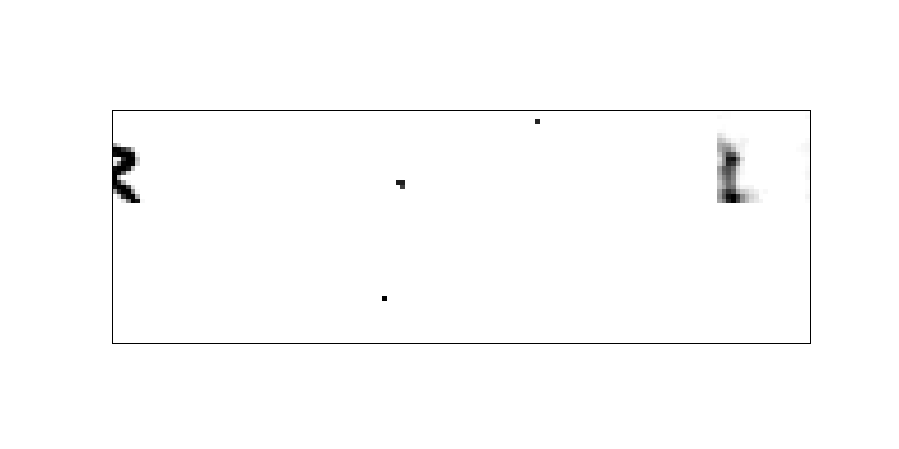

100%|██████████| 500/500 [00:02<00:00, 202.57it/s]


In [26]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

w_np = w.get()
lx_np = lat_ex.get()

ims = []
for i in tqdm(range(500)):
    v = ts_data[i].reshape(-1, 1)
    
    p = w_np @ v
    c = p + (lx_np @ p)
    winners = np.argsort(c, axis=0)[-n_w:]
    mask = np.zeros((N, 1))
    mask[winners] = 1
    o = mask * p
    r = w_np.T @ o

    o = o / max(prec, np.max(o))
    r = r / max(prec, np.max(r))
    
    mini_tap = np.zeros((50, 150))
    
    mini_tap[:20, :20] = v.reshape(20, 20)
    mini_tap[:, 50:100] = o.reshape(50, 50)
    mini_tap[:20, -20:] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=150, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

I think we both know what I have to do.  10,000 neurons, baby.

<IPython.core.display.Javascript object>


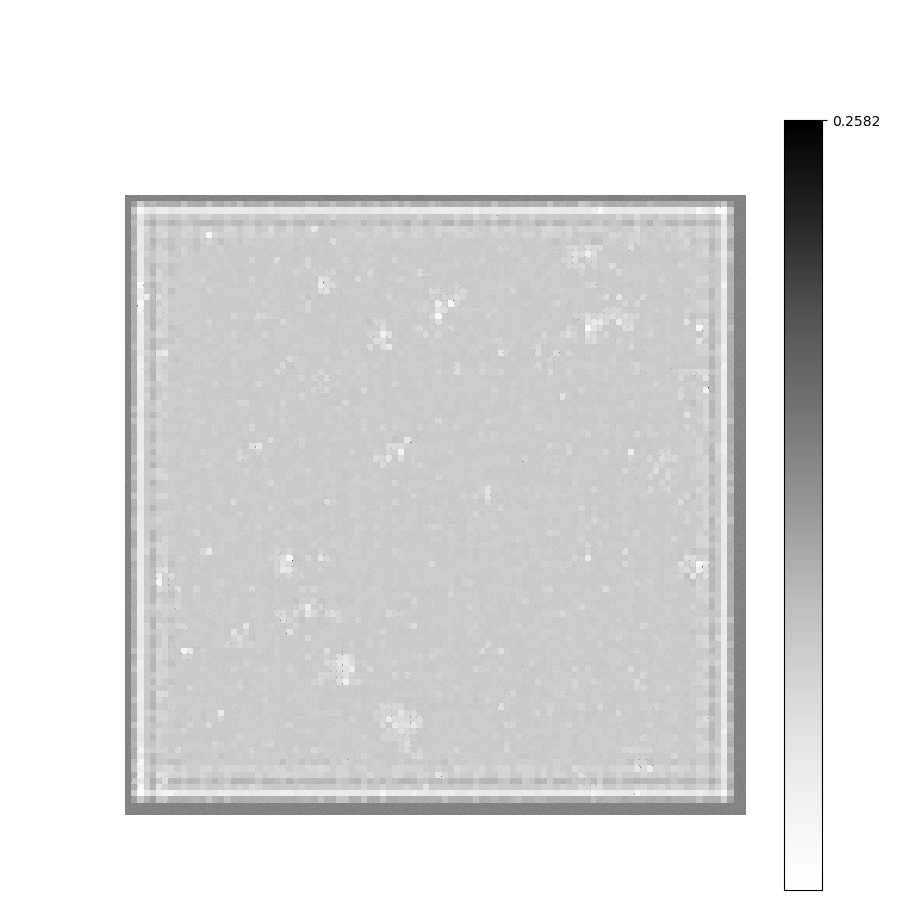

  8%|▊         | 779/10000 [00:01<00:23, 394.63it/s]


KeyboardInterrupt: 

In [27]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 10_000

Kx = 100
Ky = 100
N = Kx * Ky
m_len = sl ** 2
tr_len = img_count
ex = 2

prec = 1e-10

n_w = 5 #Number of winners

# Feedforward
w = cp.random.uniform(.15, .16, (N, m_len))
xi = 0.06

lat_ex = []

for y in range(Ky):
    for x in range(Kx):
        curr_ex = np.zeros((Ky, Kx))
        curr_ex[max(0, y - ex): min(Ky - 1, y + ex + 1), max(0, x - ex): min(Kx - 1, x + ex + 1)] = 0.1
        lat_ex.append(curr_ex.reshape(-1))
    
lat_ex = cp.array(lat_ex)
cp.fill_diagonal(lat_ex, 0)

for ep in range(Nep):
    inputs = gp_data[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        c = p + (lat_ex @ p)
        winners = cp.argsort(c, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = cp.clip(v - r, -1, 1)
        
        w += w * o * (e / mod_r).T * xi
        
    draw_weights(w.get(), Kx, Ky, sl, fig)

Nope.  That takes too long.  Let's see...

<IPython.core.display.Javascript object>


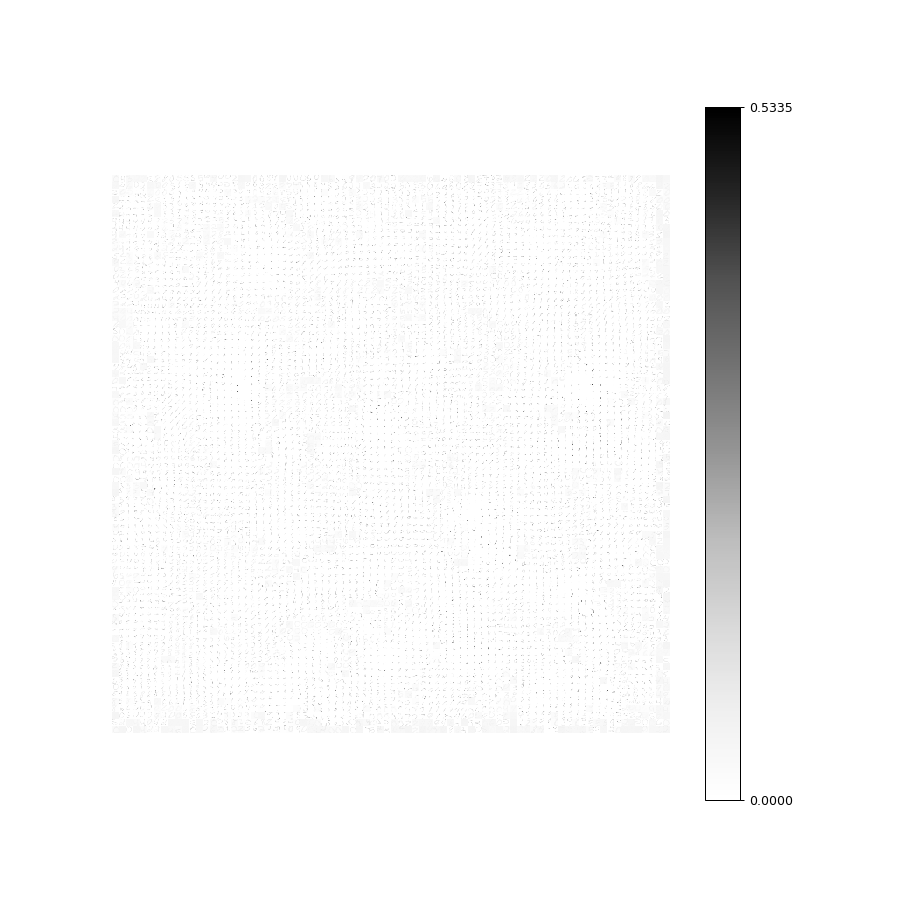

100%|██████████| 10000/10000 [00:13<00:00, 726.74it/s]


In [29]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 10_000

Kx = 80
Ky = 80
N = Kx * Ky
m_len = sl ** 2
tr_len = img_count
ex = 2

prec = 1e-10

n_w = 5 #Number of winners

# Feedforward
w = cp.random.uniform(.15, .16, (N, m_len))
xi = 0.1

lat_ex = []

for y in range(Ky):
    for x in range(Kx):
        curr_ex = np.zeros((Ky, Kx))
        curr_ex[max(0, y - ex): min(Ky - 1, y + ex + 1), max(0, x - ex): min(Kx - 1, x + ex + 1)] = 0.1
        lat_ex.append(curr_ex.reshape(-1))
    
lat_ex = cp.array(lat_ex)
cp.fill_diagonal(lat_ex, 0)

for ep in range(Nep):
    inputs = gp_data[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        c = p + (lat_ex @ p)
        winners = cp.argsort(c, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = cp.clip(v - r, -1, 1)
        
        w += w * o * (e / mod_r).T * xi
        
    draw_weights(w.get(), Kx, Ky, sl, fig)

<IPython.core.display.Javascript object>


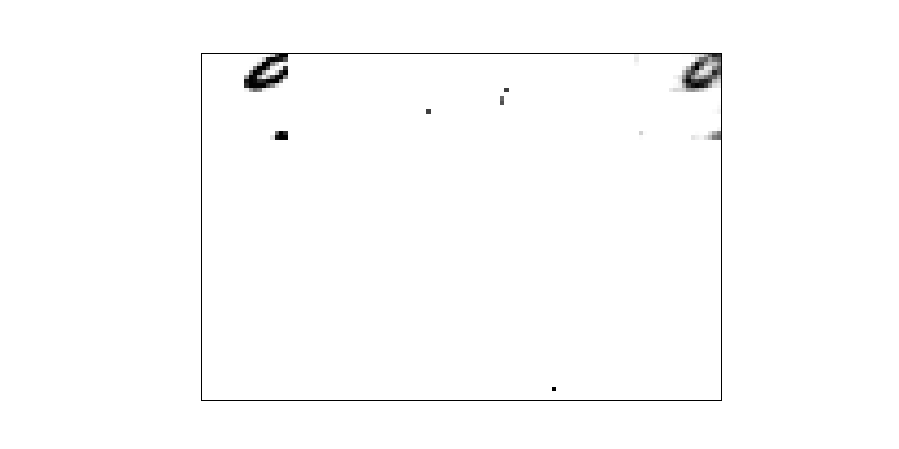

100%|██████████| 500/500 [00:09<00:00, 51.22it/s]


In [30]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

w_np = w.get()
lx_np = lat_ex.get()

ims = []
for i in tqdm(range(500)):
    v = ts_data[i].reshape(-1, 1)
    
    p = w_np @ v
    c = p + (lx_np @ p)
    winners = np.argsort(c, axis=0)[-n_w:]
    mask = np.zeros((N, 1))
    mask[winners] = 1
    o = mask * p
    r = w_np.T @ o

    o = o / max(prec, np.max(o))
    r = r / max(prec, np.max(r))
    
    mini_tap = np.zeros((80, 120))
    
    mini_tap[:20, :20] = v.reshape(20, 20)
    mini_tap[:, 20:100] = o.reshape(80, 80)
    mini_tap[:20, -20:] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=150, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

Man.  I sincerely and deeply love the topological organization I'm seeing.  It would fascinating to see what would happen with an ema.  Imma try it with 1,600 neurons.

<IPython.core.display.Javascript object>


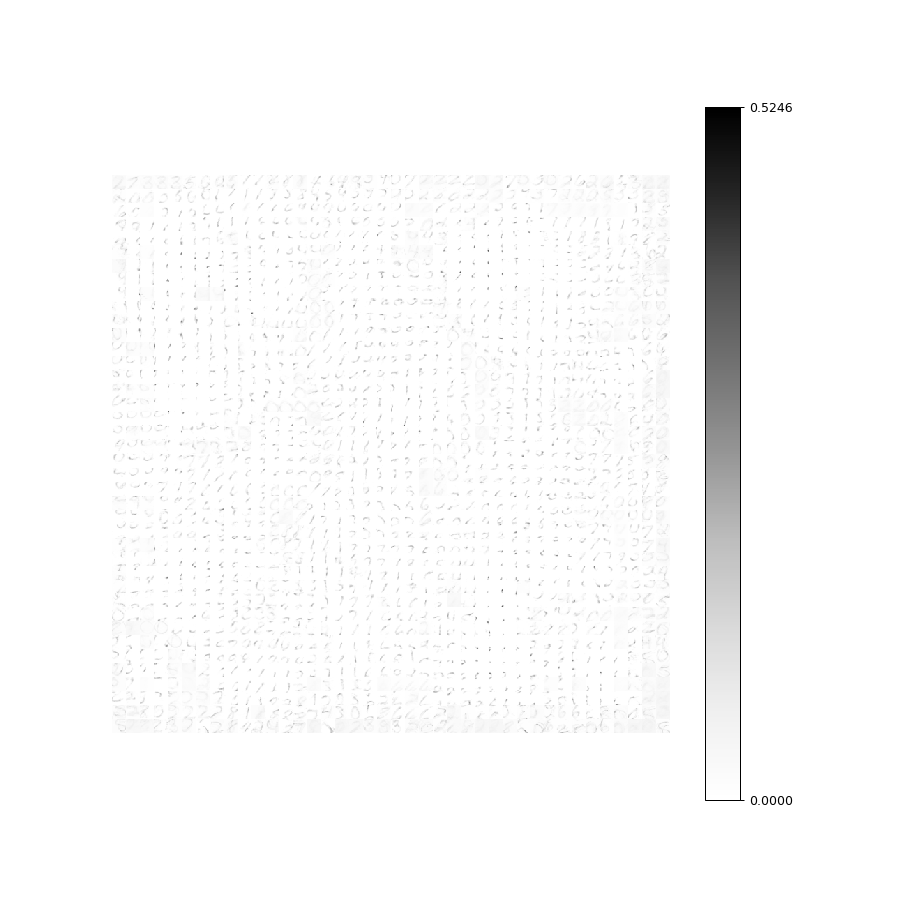

100%|██████████| 10000/10000 [00:06<00:00, 1456.96it/s]


In [31]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 10_000

Kx = 40
Ky = 40
N = Kx * Ky
m_len = sl ** 2
tr_len = img_count
ex = 2

prec = 1e-10

n_w = 5 #Number of winners

# Feedforward
w = cp.random.uniform(.15, .16, (N, m_len))
xi = 0.03

lat_ex = []

for y in range(Ky):
    for x in range(Kx):
        curr_ex = np.zeros((Ky, Kx))
        curr_ex[max(0, y - ex): min(Ky - 1, y + ex + 1), max(0, x - ex): min(Kx - 1, x + ex + 1)] = 0.1
        lat_ex.append(curr_ex.reshape(-1))
    
lat_ex = cp.array(lat_ex)
cp.fill_diagonal(lat_ex, 0)

for ep in range(Nep):
    inputs = gp_data
    o = cp.zeros((N, 1))
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        c = p + (lat_ex @ p)
        winners = cp.argsort(c, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o += ((mask * p) - o) * 0.5
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = cp.clip(v - r, -1, 1)
        
        w += w * o * (e / mod_r).T * xi
        
    draw_weights(w.get(), Kx, Ky, sl, fig)

<IPython.core.display.Javascript object>


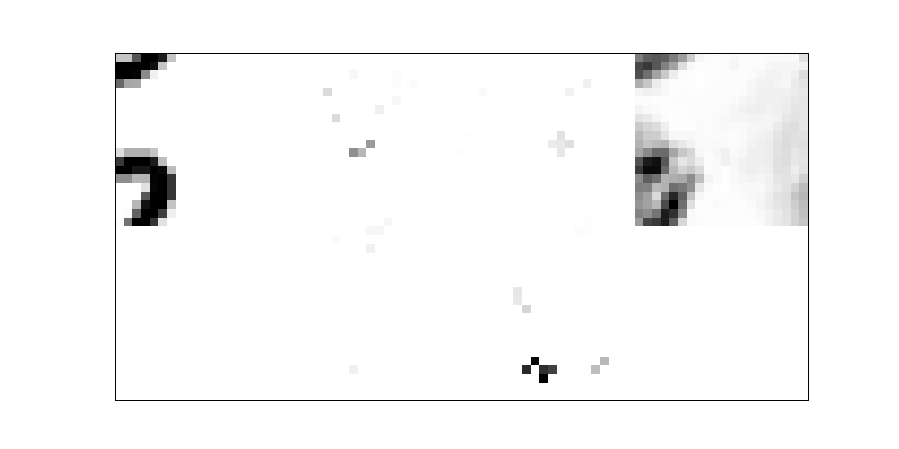

100%|██████████| 500/500 [00:01<00:00, 464.74it/s]


In [34]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

w_np = w.get()
lx_np = lat_ex.get()

ims = []
o = np.zeros((N, 1))
for i in tqdm(range(500)):
    v = ts_data[i].reshape(-1, 1)
    
    p = w_np @ v
    c = p + (lx_np @ p)
    winners = np.argsort(c, axis=0)[-n_w:]
    mask = np.zeros((N, 1))
    mask[winners] = 1
    o += ((mask * p) - o) * 0.5
    r = w_np.T @ o

    o_oo = o / max(prec, np.max(o))
    r = r / max(prec, np.max(r))
    
    mini_tap = np.zeros((40, 80))
    
    mini_tap[:20, :20] = v.reshape(20, 20)
    mini_tap[:, 20:60] = o_oo.reshape(40, 40)
    mini_tap[:20, -20:] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=150, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

Holy cow.  It's showing the trajectories.  That's incredibly dope.  Ok, I got a hike with Mal to do, so I need to go for now, but that dope, and that actually might be how I can make guesses at trajectories!! Dope!!!